# Figure 1 of paper

In [33]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
from matplotlib.path import Path

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
#from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clipped_stats
from reproject import reproject_interp

import numpy as np


import seaborn as sns
sns.set(style="dark")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [34]:
def plot_dwcs_region(imagefile,dwcsfile,ra_ref,dec_ref,im_levels=None,plot=False,color=False):
    '''
    To plot the weird dwcs lenstool files in normal coordinates.
    Parameters:
    -----------
    imagefile: string
        image where the regions were drawn
    dwcsfile: string
        contour file 
    ra_ref,dec_ref: float,float
        at the begingin of the lenstool main file (.par), where it says 'reference 3'
    im_levels: float,float
        for plotting the image
    Returns:
    --------
        polygon
    '''
    im = fits.getdata(imagefile)
    w = WCS(fits.getheader(imagefile))

    ## Read dwcs file 
    nb,cont_x,cont_y = np.loadtxt(dwcsfile,unpack=True)
            
    vertices = []
    for (x_rel,y_rel) in zip(cont_x,cont_y):
            ## putting it back to normal coordinates...
            ra  = x_rel/ (-3600*np.cos(dec_ref/180*np.pi)) + ra_ref
            dec = y_rel / 3600 + dec_ref
            ## Put back in image coordinates
            x,y = w.wcs_world2pix(ra,dec,1)
            vertices.append((x,y))
            #plt.plot(x,y,'ro',markersize=6)

    poly = Polygon(vertices,True,alpha=0.2,color='k',joinstyle='round')
      
    if plot:
        plt.figure()
        ax = plt .subplot(111)
        if im_levels == None:
                plt.imshow(im,aspect='equal')
        else:
                plt.imshow(im,aspect='equal',vmin=im_levels[0],vmax=im_levels[1])
        ax.add_collection(poly,autolim=False)
        plt.show()
    
    # Make polygon into a mask
    y, x = np.mgrid[:im.shape[0], :im.shape[1]]
    points = np.transpose((x.ravel(), y.ravel()))
    poly_path = Path(vertices)
    mask = poly_path.contains_points(points).reshape(im.shape)
    
    poly.set_facecolor('None')
    poly.set_linewidth(1)
    poly.set_alpha(1)
    if color is not False:
        poly.set_edgecolor(color)
    
    return poly,mask

In [35]:
from normalize import APLpyNormalize

def make_rgb_image(im_r,im_g,im_b,min_p=(3.,3.,3.),mid_p=(70.,70.,70.),max_p=(99.5,99.5,99.5),stretch='arcsinh',plot=False):
    '''
    Takes 3 images and makes an rgb image.
    From David Carton.
    Parameters:
    -----------
    im_r: array
        red image
    im_g: array
        green image
    im_b: array
        blue image
    min_p: float
        percentile to calculate vmin of the image
    mid_p: float
        vmid
    max_p: float
        vmax
    Returns
    -----
    image (array)
    ''' 

    valid = np.isfinite(im_r)
    valid &= np.isfinite(im_g)
    valid &= np.isfinite(im_b)

    im_r[~valid] = 0.
    im_g[~valid] = 0.
    im_b[~valid] = 0.

    vmin, vmid, vmax = np.percentile(im_r, [min_p[0], mid_p[0], max_p[0]])
    norm = APLpyNormalize(stretch=stretch, vmin=vmin, vmax=vmax,
                      vmid=vmid)
    im_r = norm(im_r, clip=True)

    vmin, vmid, vmax = np.percentile(im_g, [min_p[1], mid_p[1], max_p[1]])
    norm = APLpyNormalize(stretch=stretch, vmin=vmin, vmax=vmax,
                      vmid=vmid)
    im_g = norm(im_g, clip=True)

    vmin, vmid, vmax = np.percentile(im_b, [min_p[2], mid_p[2], max_p[2]])
    norm = APLpyNormalize(stretch=stretch, vmin=vmin, vmax=vmax,
                      vmid=vmid)
    im_b = norm(im_b, clip=True)

    image = np.array([im_r, im_g, im_b])
    image = np.rollaxis(image, 0, 3)

    if plot:
        ratio = float(image.shape[0]) / float(image.shape[1])
        fig = plt.figure(figsize=(10.,10*ratio), frameon=False)
        ax = fig.add_axes([0,0,1,1])
        ax.set_axis_off()
        ax.imshow(image, interpolation='nearest', origin='lower')
    
    return image

## AS1063

Load data

In [36]:
########## ALMA ###########
wcs_alma =  WCS(fits.getheader('../Data/Moments/as1063_mom0.fits'))
mom0 = fits.getdata('../Data/Moments/as1063_mom0.fits')
mom1 = fits.getdata('../Data/Moments/as1063_mom1.fits')
alma = fits.open('../Data/Moments/as1063_mom0.fits')[0]
_,_,rms_alma = sigma_clipped_stats(mom0[550:830,590:780])

########## HST Image ############
HST_red,_ = reproject_interp('../Data/HST/AS1063_F160w.fits',alma.header,order=0)
HST_green,_ = reproject_interp('../Data/HST/AS1063_F814w.fits',alma.header,order=0)
HST_blue,_ = reproject_interp('../Data/HST/AS1063_F435w.fits',alma.header,order=0)
rgb_as1063 = make_rgb_image(HST_red,HST_green,HST_blue,(5,5,5),(10,10,10),(99.95,99.96,99.95))

######## target region ##########
target,_ = reproject_interp('../FindClumps/as1063_target_mask.fits',alma.header,order=0)
hst_contour,_ = reproject_interp('../Data/HST/AS1063_F606W.fits',alma.header,order=0)

Plot

<IPython.core.display.Javascript object>


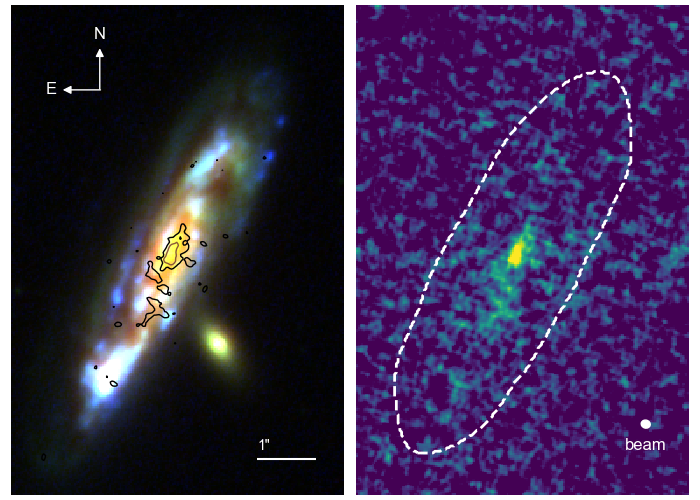

In [37]:
####### Plot ############
fig, ax = plt.subplots(1,2,figsize=(7,5))
fig.subplots_adjust(top=0.99,bottom=0.01,left=0.01,right=0.99,wspace=0.01)

ax[0].imshow(rgb_as1063[550:830,590:780],origin='lower')
ax[1].imshow(mom0[550:830,590:780],cmap='viridis',origin='lower',vmax=0.2,vmin=0)
#ax[0].contour(hst_contour[550:830,590:780],origin='lower',levels=[0.035],colors='w',linestyles='--',linewidths=2)
#ax[1].contour(hst_contour[550:830,590:780],origin='lower',levels=[0.035],colors='w',linestyles='--',linewidths=2)
ax[1].contour(target[550:830,590:780],origin='lower',levels=[0],colors='w',linestyles='--',linewidths=2)
ax[0].contour(mom0[550:830,590:780],levels=np.array((3,5,7.5))*rms_alma,cmap='copper',linewidths=1.)


###### Symbols and stuff #######
ax[0].annotate('N',xy=(50, 230),xytext=(50, 260), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',ha='center')
ax[0].annotate('E',xy=(52, 231),xytext=(19, 231), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',va='center')
ax[0].hlines(y=20,xmin=140,xmax=140+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(140, 25), color='w',fontsize=10)
ax[1].add_artist(Ellipse(xy=(165,40), width=3.8018E-05/8.333E-06, height=4.3442E-05/8.333E-06, angle=7.287213897705E+01, facecolor='w',edgecolor='w'))
ax[1].annotate('beam',(153,25),color='w',fontsize=12)

ax[0].axis('off')
ax[1].axis('off')

fig.savefig('AS1063_hst_and_alma.jpeg')

With Spectra

40 1


<IPython.core.display.Javascript object>


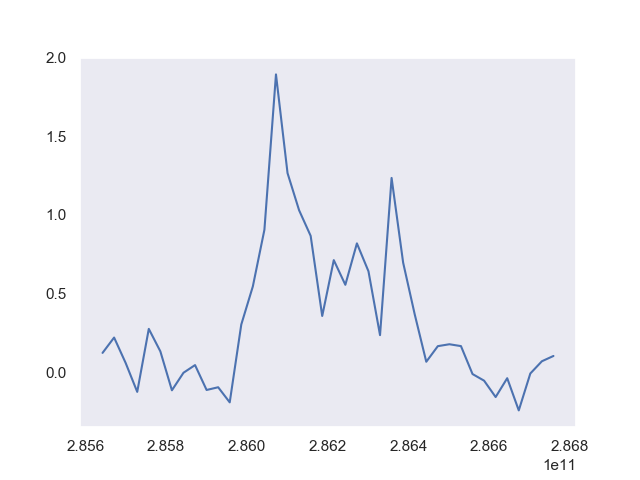

In [51]:
def open_spectra(file):
    data = fits.getdata(file)
    header = fits.getheader(file)
    freq = [header['CRVAL1'] + i*header['CDELT1'] for i in range(header['NAXIS1']) ] # In hertz
    vel = freq
    return data,vel
    
    
data,vel = open_spectra('../Data/Spectra/as1063_A_a_07_TM1_CO_4-3.image.pbcor.fits')

plt.figure()
plt.plot(vel,data)

## A521

In [38]:
########## ALMA ###########
wcs_alma =  WCS(fits.getheader('../Data/Moments/a521_mom0.fits'))
mom0 = fits.getdata('../Data/Moments/a521_mom0.fits')[635:1105,570:1090]
mom1 = fits.getdata('../Data/Moments/a521_mom1.fits')[635:1105,570:1090]
alma = fits.open('../Data/Moments/a521_mom0.fits')[0]
_,_,rms = sigma_clipped_stats(mom0)

########## HST Image ############
HST_red,_ = reproject_interp('../Data/HST/A521_F160w.fits',alma.header)
HST_green,_ = reproject_interp('../Data/HST/A521_F105w.fits',alma.header)
HST_blue,_ = reproject_interp('../Data/HST/A521_F390w.fits',alma.header)
rgb_a521 = make_rgb_image(HST_red,HST_green,HST_blue,(25,25,25),(50,50,50),(99.2,99.2,99.8),stretch='linear')[635:1105,570:1090]

######### Target region #########

target,_ = reproject_interp('../FindClumps/a521_target_mask.fits',alma.header)
target= target[635:1105,570:1090]

Multiple images

<IPython.core.display.Javascript object>


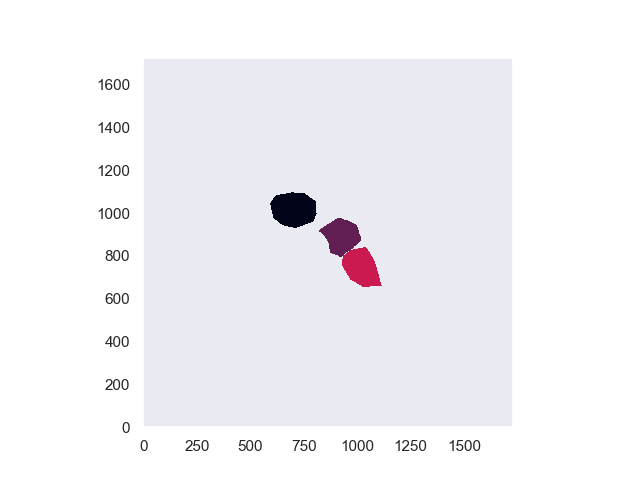

In [39]:
c_head,c_reg1,c_reg2 = '#f97306','#c20078','#3f9b0b'

reghead_poly,reghead = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/complete.dwcs',73.528753, -10.223605,color=c_head)
reg1_poly,reg1 = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/east.dwcs',73.528753, -10.223605,color=c_reg1)
reg2_poly,reg2 = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/west.dwcs',73.528753, -10.223605,color=c_reg2)

fullmask = reghead*1. + reg1*2. + reg2*3. 
fullmask[np.where(fullmask==0)] = np.nan

plt.figure()
plt.imshow(fullmask,origin='lower')
#fits.writeto('../../Data/Lensing/A370/hst_regions.fits',fullmask,header=fits.getheader('../../Data/HST/A370_F435w.fits'))

Version 2

<IPython.core.display.Javascript object>


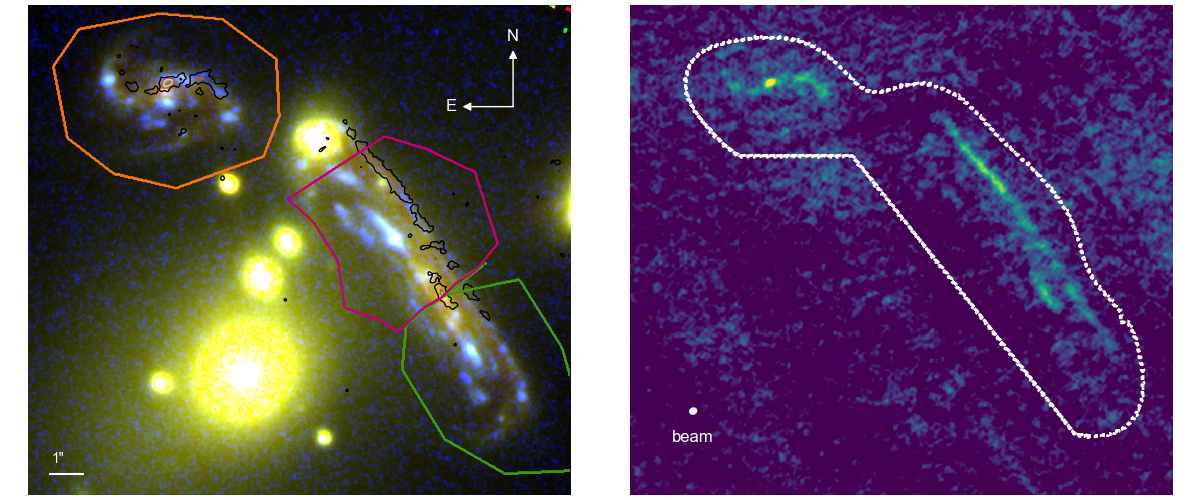

In [47]:
####### Plot ############
fig, ax = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(top=0.99,bottom=0.01,left=0.01,right=0.99,wspace=0.05)

ax[0].imshow(rgb_a521,origin='lower')
ax[1].imshow(mom0,cmap='viridis',origin='lower',vmin=0,vmax=0.15)
ax[0].contour(mom0,levels=np.array((3,5,7))*rms,cmap='copper',linewidths=1.)

ax[1].contour(target,origin='lower',colors='w',linewidths=2,linestyles=':')

# Multiple images
reghead_poly,reghead = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/complete.dwcs',73.528753, -10.223605,color=c[0])
reg1_poly,reg1 = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/east.dwcs',73.528753, -10.223605,color=c[1])
reg2_poly,reg2 = plot_dwcs_region('../Data/Moments/a521_mom0.fits','../Data/LensigStuff/A521/west.dwcs',73.528753, -10.223605,color=c[2])
ax[0].contour(reghead[635:1105,570:1090],origin='lower',colors=c[0],linewidths=1)
ax[0].contour(reg2[635:1105,570:1090],origin='lower',colors=c[2],linewidths=1)
ax[0].contour(reg1[635:1105,570:1090],origin='lower',colors=c[1],linewidths=0.9)


###### Symbols and stuff #######
ax[1].add_artist(Ellipse(xy=(60,80), width=4.733E-05/8.333E-06, height=5.642E-05/8.333E-06, angle=-7.125E+01, facecolor='w',edgecolor='w'))
ax[1].annotate('beam',(40,50),color='w',fontsize=12)
ax[0].hlines(y=20,xmin=20,xmax=20+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(22, 30), color='w',fontsize=10)
ax[0].annotate('N',xy=(15+450, 370),xytext=(15+450, 435), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',ha='center')
ax[0].annotate('E',xy=(48+420, 372),xytext=(400, 372), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',va='center')
ax[0].axis('off')
ax[1].axis('off')

fig.savefig('A521_hst_and_alma.jpeg')

## MACS1206

In [49]:
########## ALMA ###########
wcs_alma =  WCS(fits.getheader('../Data/Moments/snake_mom0.fits'))
mom0 = fits.getdata('../Data/Moments/snake_mom0.fits')[280:740,410:580]
mom1 = fits.getdata('../Data/Moments/snake_mom1.fits')
alma = fits.open('../Data/Moments/snake_mom0.fits')[0]
_,_,rms = sigma_clipped_stats(mom0)
print(rms)

########## HST Image ############
HST_red,_ = reproject_interp('../Data/HST/snake_F160W.fits',alma.header)
HST_green,_ = reproject_interp('../Data/HST/snake_F814W.fits',alma.header)
HST_blue,_ = reproject_interp('../Data/HST/snake_F435W.fits',alma.header)
rgb_snake = make_rgb_image(HST_red,HST_green,HST_blue,(5,5,5),(10,10,10),(99.93,99.91,99.94))[280:740,410:580]

######### target ################
target,_ = reproject_interp('../FindClumps/snake_target_mask.fits',alma.header)
target = target[280:740,410:580]

## MUSE ##
#oii_vel, _ = reproject_interp('../MUSE/MACS1206_model_atan.fits',alma.header)
#oii_vel[np.where(oii_vel == 0)] = np.nan

0.023999829
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
 

<IPython.core.display.Javascript object>


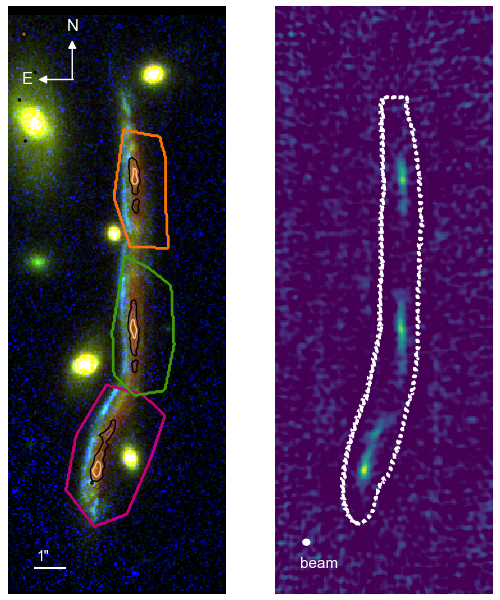

In [50]:
####### Plot ############
fig, ax = plt.subplots(1,2,figsize=(5,6))
fig.subplots_adjust(top=0.99,bottom=0.01,left=0.01,right=0.99)

ax[0].imshow(rgb_snake,origin='lower')
ax[1].imshow(mom0,cmap='viridis',origin='lower',vmin=0)
ax[0].contour(mom0,levels=np.array((3,5,7))*rms,cmap='copper',linewidths=1.)

_,reg_north = plot_dwcs_region('../Data/Moments/snake_mom0.fits','../Data/LensigStuff/MACS1206/north.dwcs',181.550606, -8.800926 ,color=c[0])
_,reg_south = plot_dwcs_region('../Data/Moments/snake_mom0.fits','../Data/LensigStuff/MACS1206/south.dwcs',181.550606, -8.800926,color=c[1])
_,reg_centre = plot_dwcs_region('../Data/Moments/snake_mom0.fits','../Data/LensigStuff/MACS1206/centre.dwcs',181.550606, -8.800926,color=c[2])

ax[0].contour(reg_north[280:740,410:580],origin='lower',colors=c[0],linewidths=1)
ax[0].contour(reg_south[280:740,410:580],origin='lower',colors=c[1],linewidths=1)
ax[0].contour(reg_centre[280:740,410:580],origin='lower',colors=c[2],linewidths=1)

ax[1].contour(target,origin='lower',colors='w',linewidths=2,linestyles=':')

###### Symbols and stuff #######
ax[1].add_artist(Ellipse(xy=(24,40), width=5.084E-05/1.11E-05, height=5.98E-05/1.11E-05, angle=8.489570617676E+01, facecolor='w',edgecolor='w'))
ax[1].annotate('beam',(19,20),color='w',fontsize=11)
ax[0].hlines(y=20,xmin=20,xmax=20+(1/(1.111111111111E-05 *3600)),color='w')
ax[0].annotate('1"',xy=(22, 25), color='w',fontsize=10)
ax[0].annotate('N',xy=(50, 400),xytext=(50, 440), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',ha='center')
ax[0].annotate('E',xy=(53, 402),xytext=(10, 402), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',va='center')
ax[1].axis('off')
ax[0].axis('off')

fig.savefig('snake_hst_and_alma.jpeg')